In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
%matplotlib inline

import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")

import nanonets_utils

In [19]:
def average_outputs(folder, N_stat, N_threads):

    values          = [pd.read_csv(folder+f"/Nx=7_Ny=7_Nz=1_Ne=2_t{j}_s{k}.csv") for j in range(N_threads) for k in range(N_stat)]
    means           = pd.DataFrame(np.mean(values, axis=0),columns=values[0].columns)
    means['Error']  = np.std(values,axis=0)[:,-2]/np.sqrt(50)

    means.to_csv(folder+f"/Nx=7_Ny=7_Nz=1_Ne=2.csv", index=0)

def average_states(folder, N_stat, N_threads):

    values  = [pd.read_csv(folder+f"/mean_state_Nx=7_Ny=7_Nz=1_Ne=2_t{j}_s{k}.csv") for j in range(N_threads) for k in range(N_stat)]
    means   = pd.DataFrame(np.mean(values, axis=0),columns=values[0].columns).round(3)
    
    means.to_csv(folder+f"/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv", index=0)

# Combine output currents
average_outputs("1I_1O/data/", 10, 10)
average_outputs("1I_1O_radius_dis/data/", 10, 10)
average_outputs("1I_1O_high_radius/data/", 10, 10)
average_outputs("1I_1O_R_dis/data/", 10, 10)

# Combine states
average_states("1I_1O/data/", 10 , 10)
average_states("1I_1O_radius_dis/data/", 10 , 10)
average_states("1I_1O_high_radius/data/", 10, 10)
average_states("1I_1O_R_dis/data/", 10 , 10)

In [20]:
results         = pd.DataFrame()
results["t"]    = np.loadtxt("1I_1O/time.csv")[1:]*10**9
results['U']    = pd.read_csv("1I_1O/data/Nx=7_Ny=7_Nz=1_Ne=2.csv")['E0']

results["I"]    = pd.read_csv("1I_1O/data/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
results["uI"]   = pd.read_csv("1I_1O/data/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']

results["r_I"]  = pd.read_csv("1I_1O_radius_dis/data/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
results["r_uI"] = pd.read_csv("1I_1O_radius_dis/data/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']

results["hr_I"]  = pd.read_csv("1I_1O_high_radius/data/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
results["hr_uI"] = pd.read_csv("1I_1O_high_radius/data/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']

results["R_I"]  = pd.read_csv("1I_1O_R_dis/data/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
results["R_uI"] = pd.read_csv("1I_1O_R_dis/data/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']

results

,t,U,I,uI,r_I,r_uI,hr_I,hr_uI,R_I,R_uI
0,0.1,0.1,900.0,404.722127,1300.0,475.604878,3500.0,857.321410,900.0,404.722127
1,0.2,0.1,1500.0,504.975247,800.0,383.666522,3900.0,846.049644,1500.0,504.975247
2,0.3,0.1,700.0,360.832371,700.0,360.832371,3400.0,727.186359,800.0,383.666522
3,0.4,0.1,700.0,360.832371,800.0,432.666153,3400.0,754.188305,400.0,277.128129
4,0.5,0.1,1600.0,518.459256,400.0,277.128129,4600.0,946.995248,1400.0,490.713766
...,...,...,...,...,...,...,...,...,...,...
994,99.5,0.1,600.0,335.857112,600.0,335.857112,4900.0,948.577883,900.0,404.722127
995,99.6,0.1,1700.0,531.224999,500.0,308.220700,4400.0,1045.370748,700.0,360.832371
996,99.7,0.1,1200.0,459.565012,400.0,277.128129,4700.0,904.544084,1000.0,424.264069
997,99.8,0.1,800.0,383.666522,400.0,277.128129,4500.0,902.773504,1200.0,459.565012


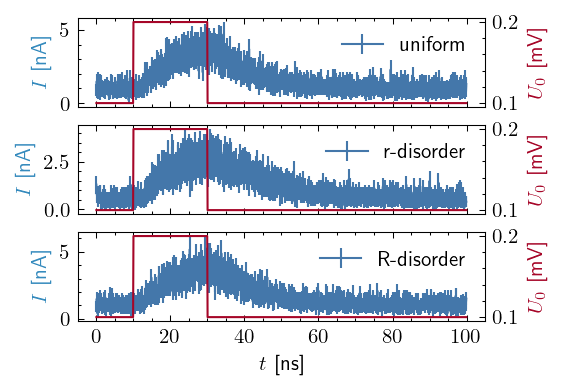

In [17]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=150)
    fig.set_figheight(fig.get_figheight())
    
    ax  = fig.add_subplot(3,1,1)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')

    ax.errorbar(results['t'], results['I']/1000, results['uI']/1000, label='uniform')
    ax.set_xticklabels("")
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.legend()

    ax  = fig.add_subplot(3,1,2)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['r_I']/1000, results['r_uI']/1000, label='r-disorder')
    ax.set_xticklabels("")
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.legend()

    ax  = fig.add_subplot(3,1,3)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['R_I']/1000, results['R_uI']/1000, label='R-disorder')
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.set_xlabel("$t$ [ns]")
    ax.legend()

    fig.savefig('plots/i_o_comp.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/i_o_comp.pdf', bbox_inches='tight', transparent=False)

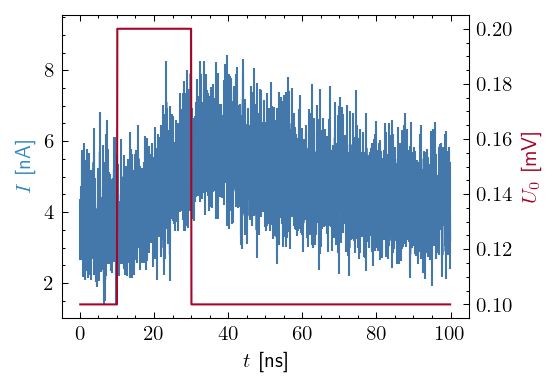

In [23]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=150)
    
    ax  = fig.add_subplot()
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')

    ax.errorbar(results['t'], results['hr_I']/1000, results['hr_uI']/1000, label='uniform')
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$I$ [nA]", c='#348ABD')

    fig.savefig('plots/i_o_comp_high_radius.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/i_o_comp_high_radius.pdf', bbox_inches='tight', transparent=False)

MovieWriter ffmpeg unavailable; using Pillow instead.


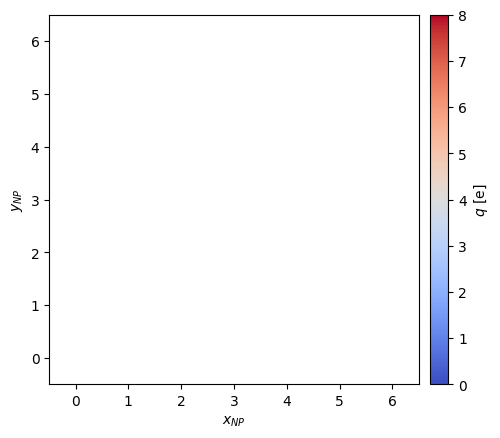

In [24]:
ani = nanonets_utils.animate_landscape("1I_1O_radius_dis/data/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv", 7 , 7,
                                       delay_between_frames=50, interpolation='bilinear', cbar_label='$q$ [e]',
                                       vmin=0, vmax=8)
ani.save("plots/state_animation_radius.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


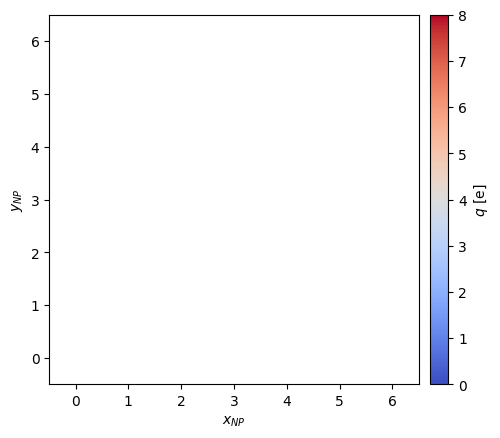

In [25]:
ani = nanonets_utils.animate_landscape("1I_1O_R_dis/data/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv", 7 , 7,
                                       delay_between_frames=50, interpolation='bilinear', cbar_label='$q$ [e]',
                                       vmin=0, vmax=8)
ani.save("plots/state_animation_resistance.gif")

In [10]:
# def load_data(folder, N_dev, N_stat, N_threads, Nx=7, Ny=7):

#     dic = {}

#     for d in range(1,N_dev+1):

#         values  = [pd.read_csv(folder+f"/d{d}/Nx={Nx}_Ny={Ny}_Nz=1_Ne=2_t{j}_s{k}.csv") for j in range(N_threads) for k in range(N_stat)]
        
#         means           = pd.DataFrame(np.mean(values, axis=0),columns=values[0].columns)
#         means['Error']  = np.std(values,axis=0)[:,-2]/np.sqrt(50)

#         dic[d]  = means

#         means.to_csv(folder+f"/d{d}/Nx={Nx}_Ny={Ny}_Nz=1_Ne=2.csv", index=0)

#     return dic

# def average_states(folder, N_dev, N_stat, N_threads, Nx=7, Ny=7):

#     for d in range(1,N_dev+1):

#         values  = [pd.read_csv(folder+f"/d{d}/mean_state_Nx={Nx}_Ny={Ny}_Nz=1_Ne=2_t{j}_s{k}.csv") for j in range(N_threads) for k in range(N_stat)]
#         means   = pd.DataFrame(np.mean(values, axis=0),columns=values[0].columns).round(3)
        
#         means.to_csv(folder+f"/d{d}/mean_state_Nx={Nx}_Ny={Ny}_Nz=1_Ne=2.csv", index=0)

# time    = np.loadtxt("1I_1O/time.csv")[1:]*10**9
# dic     = load_data("1I_1O", 1, 5, 10)
# dic_r   = load_data("1I_1O_radius_dis", 3, 5, 10)
# dic_R   = load_data("1I_1O_R_dis", 3, 5, 10)

In [4]:
# dic_s   = {d : pd.read_csv(f'1I_1O/d{d}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv') for d in range(1,2)}
# dic_s_R = {d : pd.read_csv(f'1I_1O_R_dis/d{d}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv') for d in range(1,2)}
# dic_s_r = {d : pd.read_csv(f'1I_1O_radius_dis/d{d}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv') for d in range(1,2)}

In [5]:
# for key, df in dic.items():
#     df.to_csv(f"1I_1O/d{key}/Nx=5_Ny=5_Nz=1_Ne=2.csv", index=0)

# for key, df in dic_R.items():
#     df.to_csv(f"1I_1O_R_dis/d{key}/Nx=5_Ny=5_Nz=1_Ne=2.csv", index=0)

# for key, df in dic_r.items():
#     df.to_csv(f"1I_1O_radius_dis/d{key}/Nx=5_Ny=5_Nz=1_Ne=2.csv", index=0)